## 📊 ¿Por qué el Accuracy es Insuficiente?

### El Caso del Banco 🏦

Un banco quiere predecir qué clientes caerán en **default** (no pagarán su préstamo).

| Escenario | Predicción | Realidad | ¿Qué pasa? |
|-----------|------------|----------|------------|
| **TN** (True Negative) | "Pagará" ✅ | Pagó ✅ | **Ganamos intereses** (+$500) |
| **TP** (True Positive) | "No pagará" ❌ | No pagó ❌ | **Evitamos pérdida** ($0) |
| **FP** (False Positive) | "No pagará" ❌ | Sí pagó ✅ | **Perdemos cliente** (-$100) |
| **FN** (False Negative) | "Pagará" ✅ | No pagó ❌ | **PERDEMOS TODO** (-$2,000) |

### 💡 Insight Clave
**No todos los errores cuestan lo mismo.** Un Falso Negativo (FN) nos cuesta **20 veces más** que un Falso Positivo (FP).

El Accuracy trata todos los errores como iguales. **El dinero no.**

## 🧮 La Matriz de Costos/Beneficios

Antes de calcular ganancias, debemos definir cuánto vale cada decisión:

```
                    PREDICCIÓN
                 Negativo    Positivo
              ┌───────────┬───────────┐
    Negativo  │  TN: +500 │  FP: -100 │
REAL          ├───────────┼───────────┤
    Positivo  │ FN: -2000 │   TP: 0   │
              └───────────┴───────────┘
```

**Interpretación:**
- **Negativo = Buen Pagador** (Clase 0)
- **Positivo = Default** (Clase 1)

In [1]:
# 🛠️ Librerías
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("✅ Librerías cargadas")


✅ Librerías cargadas


## 🎲 Simulación: Un Modelo Ficticio

Vamos a crear un escenario simulado para entender las Profit Curves sin complicaciones de datos reales.

In [2]:
# Simulamos 1000 clientes
np.random.seed(42)
n_clientes = 1000

# 20% son defaults (realidad)
y_true = np.array([1] * 200 + [0] * 800)
np.random.shuffle(y_true)

# Simulamos las probabilidades predichas por un modelo
# Los defaults tienden a tener probabilidades más altas
y_prob = np.where(
    y_true == 1,
    np.clip(np.random.beta(5, 2, n_clientes),
            0.1, 0.95),  # Defaults: probs altas
    np.clip(np.random.beta(2, 5, n_clientes),
            0.05, 0.9)   # Buenos: probs bajas
)

print(f"Total clientes: {n_clientes}")
print(f"Defaults reales: {y_true.sum()} ({y_true.mean()*100:.1f}%)")
print(f"Rango de probabilidades: [{y_prob.min():.2f}, {y_prob.max():.2f}]")


Total clientes: 1000
Defaults reales: 200 (20.0%)
Rango de probabilidades: [0.05, 0.95]


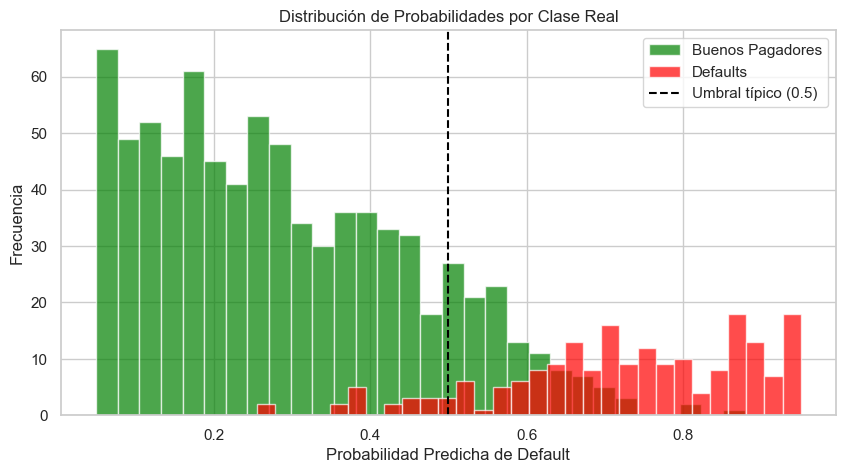

In [3]:
# Visualizar la distribución de probabilidades
fig, ax = plt.subplots(figsize=(10, 5))

ax.hist(y_prob[y_true == 0], bins=30, alpha=0.7,
        label='Buenos Pagadores', color='green')
ax.hist(y_prob[y_true == 1], bins=30, alpha=0.7, label='Defaults', color='red')

ax.axvline(0.5, color='black', linestyle='--', label='Umbral típico (0.5)')
ax.set_xlabel('Probabilidad Predicha de Default')
ax.set_ylabel('Frecuencia')
ax.set_title('Distribución de Probabilidades por Clase Real')
ax.legend()
plt.show()


## 🚦 El Umbral de Decisión (Threshold)

El modelo produce **probabilidades** (0 a 1). Nosotros decidimos el **umbral** para convertirlas en decisiones:

- Si `P(Default) >= threshold` → **Rechazar préstamo** (Predecir Default)
- Si `P(Default) < threshold` → **Aprobar préstamo** (Predecir Buen Pagador)

### ¿Y si cambiamos el umbral?

| Umbral | Efecto |
|--------|--------|
| **Bajo (0.2)** | Rechazamos más → Menos FN pero más FP |
| **Alto (0.8)** | Aprobamos más → Menos FP pero más FN |
| **Default (0.5)** | Balance estándar |

In [4]:
def calcular_metricas(y_true, y_prob, threshold):
    """Calcula métricas para un umbral dado."""
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    return {
        'threshold': threshold,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall
    }


# Comparar 3 umbrales
for t in [0.3, 0.5, 0.7]:
    m = calcular_metricas(y_true, y_prob, t)
    print(f"\n📊 Umbral = {t}")
    print(f"   Accuracy: {m['accuracy']:.2%}")
    print(f"   Precision: {m['precision']:.2%}")
    print(f"   Recall: {m['recall']:.2%}")
    print(f"   Matriz: TN={m['tn']}, FP={m['fp']}, FN={m['fn']}, TP={m['tp']}")



📊 Umbral = 0.3
   Accuracy: 66.30%
   Precision: 37.15%
   Recall: 99.00%
   Matriz: TN=465, FP=335, FN=2, TP=198

📊 Umbral = 0.5
   Accuracy: 86.40%
   Precision: 60.81%
   Recall: 90.00%
   Matriz: TN=684, FP=116, FN=20, TP=180

📊 Umbral = 0.7
   Accuracy: 91.20%
   Precision: 93.08%
   Recall: 60.50%
   Matriz: TN=791, FP=9, FN=79, TP=121


## 💰 Calculando la Ganancia (Profit)

Ahora viene la magia. Convertimos la matriz de confusión en **dinero**.

```python
Profit = (TN × Beneficio_TN) + (TP × Beneficio_TP) + (FP × Costo_FP) + (FN × Costo_FN)
```

In [5]:
# Definir la matriz de costos/beneficios
BENEFICIO_TN = 500    # Ganancia por aprobar a un buen pagador
BENEFICIO_TP = 0      # No perdemos nada al rechazar un default
COSTO_FP = -100       # Costo de rechazar a un buen cliente
COSTO_FN = -2000      # Pérdida por aprobar a un default


def calcular_profit(y_true, y_prob, threshold):
    """Calcula el profit total para un umbral dado."""
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

    profit = (tn * BENEFICIO_TN) + (tp * BENEFICIO_TP) + \
        (fp * COSTO_FP) + (fn * COSTO_FN)
    return profit, tn, fp, fn, tp


# Comparar el profit para diferentes umbrales
print("💵 COMPARACIÓN DE GANANCIAS\n")
for t in [0.3, 0.5, 0.7]:
    profit, tn, fp, fn, tp = calcular_profit(y_true, y_prob, t)
    print(f"Umbral {t}: Profit = ${profit:,.0f}")
    print(
        f"   Desglose: TN={tn}(+${tn*BENEFICIO_TN:,}), FP={fp}(${fp*COSTO_FP:,}), FN={fn}(${fn*COSTO_FN:,}), TP={tp}")
    print()


💵 COMPARACIÓN DE GANANCIAS

Umbral 0.3: Profit = $195,000
   Desglose: TN=465(+$232,500), FP=335($-33,500), FN=2($-4,000), TP=198

Umbral 0.5: Profit = $290,400
   Desglose: TN=684(+$342,000), FP=116($-11,600), FN=20($-40,000), TP=180

Umbral 0.7: Profit = $236,600
   Desglose: TN=791(+$395,500), FP=9($-900), FN=79($-158,000), TP=121



## 📈 La Profit Curve

¿Y si probamos **todos** los umbrales posibles? Eso es una **Profit Curve**.

In [6]:
# Calcular profit para 100 umbrales
thresholds = np.linspace(0.01, 0.99, 100)
profits = [calcular_profit(y_true, y_prob, t)[0] for t in thresholds]

# Encontrar el óptimo
idx_optimo = np.argmax(profits)
threshold_optimo = thresholds[idx_optimo]
profit_optimo = profits[idx_optimo]

# También calcular profit con umbral default (0.5)
profit_default = calcular_profit(y_true, y_prob, 0.5)[0]

print(f"🎯 Umbral Óptimo: {threshold_optimo:.2f}")
print(f"💰 Profit Máximo: ${profit_optimo:,.0f}")
print(f"📉 Profit con umbral 0.5: ${profit_default:,.0f}")
print(f"📈 Diferencia: ${profit_optimo - profit_default:,.0f} ({(profit_optimo - profit_default) / abs(profit_default) * 100:.1f}% más)")


🎯 Umbral Óptimo: 0.55
💰 Profit Máximo: $309,000
📉 Profit con umbral 0.5: $290,400
📈 Diferencia: $18,600 (6.4% más)


C:\Users\Theki\AppData\Local\Temp\ipykernel_34164\1348647244.py:35: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) Arial.
  plt.tight_layout()
c:\ProgramData\Anaconda3\envs\ml_pro\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128181 (\N{BANKNOTE WITH DOLLAR SIGN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


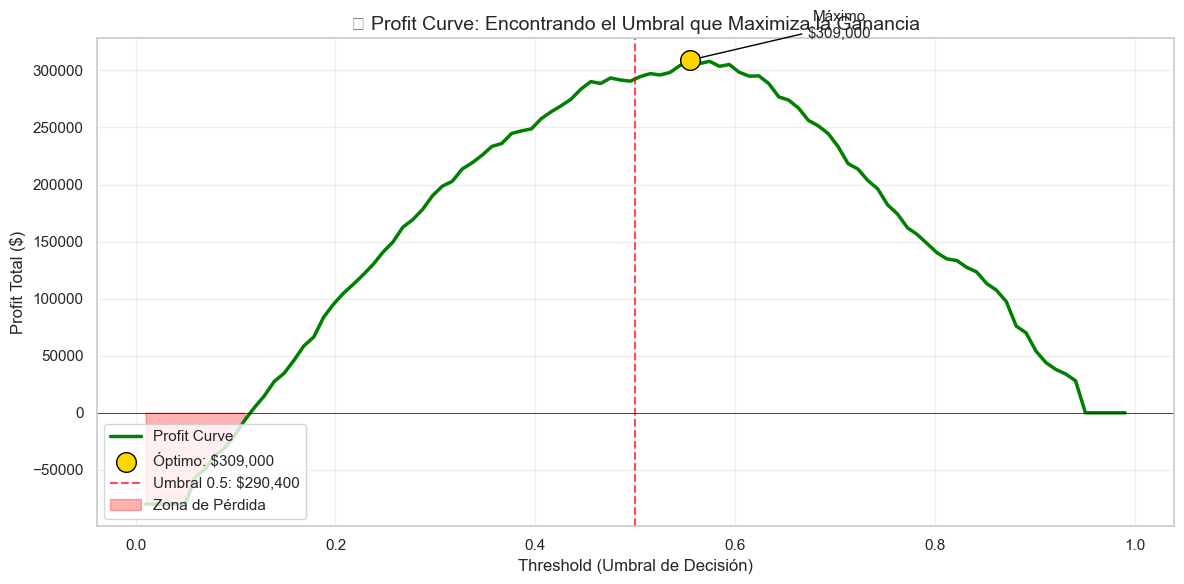

In [7]:
# Visualizar la Profit Curve
fig, ax = plt.subplots(figsize=(12, 6))

# Curva principal
ax.plot(thresholds, profits, linewidth=2.5,
        color='green', label='Profit Curve')

# Marcar el óptimo
ax.scatter([threshold_optimo], [profit_optimo], s=200, color='gold',
           edgecolor='black', zorder=5, label=f'Óptimo: ${profit_optimo:,.0f}')

# Marcar el default
ax.axvline(0.5, color='red', linestyle='--', alpha=0.7,
           label=f'Umbral 0.5: ${profit_default:,.0f}')

# Zona de pérdida
ax.axhline(0, color='black', linewidth=0.5)
ax.fill_between(thresholds, profits, 0, where=np.array(profits) < 0,
                alpha=0.3, color='red', label='Zona de Pérdida')

ax.set_xlabel('Threshold (Umbral de Decisión)', fontsize=12)
ax.set_ylabel('Profit Total ($)', fontsize=12)
ax.set_title(
    '💵 Profit Curve: Encontrando el Umbral que Maximiza la Ganancia', fontsize=14)
ax.legend(loc='lower left')
ax.grid(True, alpha=0.3)

# Añadir anotación
ax.annotate(f'Máximo\n${profit_optimo:,.0f}',
            xy=(threshold_optimo, profit_optimo),
            xytext=(threshold_optimo + 0.15, profit_optimo + 20000),
            fontsize=11, ha='center',
            arrowprops=dict(arrowstyle='->', color='black'))

plt.tight_layout()
plt.show()


## 🤔 ¿Por qué el Umbral Óptimo NO es 0.5?

El umbral **0.5** asume que:
1. Los errores (FP y FN) tienen el mismo costo.
2. Las clases están balanceadas.

**En el mundo real, esto casi nunca es cierto.**

En nuestro caso:
- Un FN cuesta **$2,000** (aprobar a alguien que hará default).
- Un FP cuesta solo **$100** (rechazar a un buen cliente).

Por eso, **conviene ser más conservador** (umbral más bajo) para evitar los costosos FN, aunque eso signifique más FP.

## 🔬 Análisis de Sensibilidad

¿Qué pasa si los costos cambian? Veamos cómo el umbral óptimo depende de la estructura de costos.

In [8]:
def encontrar_umbral_optimo(y_true, y_prob, costo_fn, costo_fp=COSTO_FP, beneficio_tn=BENEFICIO_TN):
    """Encuentra el umbral óptimo para una estructura de costos dada."""
    thresholds = np.linspace(0.01, 0.99, 100)
    profits = []

    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        profit = (tn * beneficio_tn) + (fp * costo_fp) + (fn * costo_fn)
        profits.append(profit)

    idx = np.argmax(profits)
    return thresholds[idx], profits[idx]


# Probar diferentes costos de FN
costos_fn = [-500, -1000, -2000, -5000, -10000]

print("📊 Umbral Óptimo según el Costo del Falso Negativo\n")
print(f"{'Costo FN':<15} {'Umbral Óptimo':<18} {'Profit Máximo'}")
print("-" * 50)

umbrales_optimos = []
for costo in costos_fn:
    umbral, profit = encontrar_umbral_optimo(y_true, y_prob, costo)
    umbrales_optimos.append(umbral)
    print(f"${abs(costo):,}          {umbral:.2f}               ${profit:,.0f}")


📊 Umbral Óptimo según el Costo del Falso Negativo

Costo FN        Umbral Óptimo      Profit Máximo
--------------------------------------------------
$500          0.62               $361,200
$1,000          0.59               $341,200
$2,000          0.55               $309,000
$5,000          0.46               $254,200
$10,000          0.36               $217,400
$5,000          0.46               $254,200
$10,000          0.36               $217,400


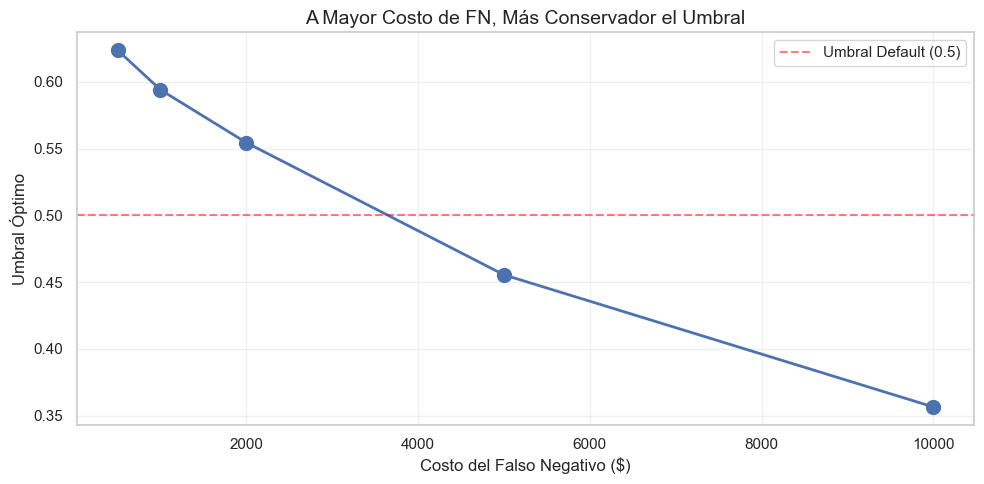

In [9]:
# Visualizar la relación
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot([abs(c) for c in costos_fn], umbrales_optimos,
        marker='o', markersize=10, linewidth=2)
ax.set_xlabel('Costo del Falso Negativo ($)', fontsize=12)
ax.set_ylabel('Umbral Óptimo', fontsize=12)
ax.set_title('A Mayor Costo de FN, Más Conservador el Umbral', fontsize=14)
ax.axhline(0.5, color='red', linestyle='--',
           alpha=0.5, label='Umbral Default (0.5)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 🏁 Conclusiones

### Lo que aprendimos:

1. **El Accuracy miente** cuando los costos de los errores son asimétricos.

2. **La Profit Curve** traduce las métricas técnicas a lenguaje de negocio ($$$).

3. **El umbral 0.5 es arbitrario.** El umbral óptimo depende de:
   - La matriz de costos/beneficios
   - La distribución de clases
   - El apetito de riesgo del negocio

4. **Siempre pregunta:** "¿Cuánto cuesta equivocarnos?" antes de elegir un umbral.

---

### 📚 Para Practicar

1. Cambia los valores de la matriz de costos y observa cómo cambia el umbral óptimo.
2. ¿Qué pasa si los defaults son el 5% en lugar del 20%?
3. Intenta crear una función que optimice el umbral para tu propio dataset.

---

## 🎯 Resumen Visual

```
┌─────────────────────────────────────────────────────────────┐
│                    PROFIT CURVE WORKFLOW                    │
├─────────────────────────────────────────────────────────────┤
│                                                             │
│  1. DEFINE TU MATRIZ DE COSTOS                              │
│     └─> ¿Cuánto cuesta cada tipo de error?                  │
│                                                             │
│  2. CALCULA PROFIT PARA CADA UMBRAL                         │
│     └─> Profit = Σ(Beneficios) - Σ(Costos)                  │
│                                                             │
│  3. ENCUENTRA EL UMBRAL ÓPTIMO                              │
│     └─> argmax(Profit)                                      │
│                                                             │
│  4. COMUNICA EN LENGUAJE DE NEGOCIO                         │
│     └─> "Este umbral genera $X adicionales"                 │
│                                                             │
└─────────────────────────────────────────────────────────────┘
```

**¡Ahora puedes responder cuánto dinero genera tu modelo!** 🚀